## Initial Setup

In [ ]:
#pip install keras-cv

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project')

In [11]:
import pandas as pd
import numpy as np
import keras
from keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB4, EfficientNetB7, EfficientNetV2M, ResNet50V2, ResNet152V2, InceptionV3, DenseNet121, DenseNet201
import tensorflow as tf
from isic2018_task3_data_preprocessing import DataBalancer, DataPreparer, ModelSpecificProcessor
from isic2018_task3_models import BaseModel
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
import keras_cv
from sklearn.utils import resample

## Data Pre-Processing

In [8]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/train/ISIC2018_Task3_Training_GroundTruth.csv')
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
base_path = '/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/train/images/'
df['img_path'] = base_path + df['image']+'.jpg'
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,img_path
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...


In [16]:
classes = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
df['label'] = df[classes].idxmax(axis=1)
target_counts = {"AKIEC":1350, "BCC":1170, "BKL":1080, "DF":1620, "NV":900, "MEL":1980, "VASC":914}
df_balanced = pd.DataFrame(columns=df.columns)

for label, target_count in target_counts.items():
    df_class = df[df['label'] == label]
    current_count = len(df_class)

    if current_count < target_count:
        # Upsample
        df_class_balanced = resample(df_class, replace=True, n_samples=target_count, random_state=42)
    else:
        # Downsample
        df_class_balanced = resample(df_class, replace=False, n_samples=target_count, random_state=42)

    df_balanced = pd.concat([df_balanced, df_class_balanced])

df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

/tmp/ipython-input-16-3881817062.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_balanced = pd.concat([df_balanced, df_class_balanced])


In [19]:
total = sum(target_counts.values())
total

9014

In [22]:
class_weights = {cls: total / (len(classes) * count) for cls, count in target_counts.items()}
# Map the classes and weights to be acceptable in model fit
class_indices = {cls: i for i, cls in enumerate(classes)}
class_weight_idx = {class_indices[cls]: weight for cls, weight in class_weights.items()}

print("Class weights (inverse frequency):", class_weights)
print("Final dict:", class_weight_idx)

Class weights (inverse frequency): {'AKIEC': 0.9538624338624339, 'BCC': 1.1006105006105007, 'BKL': 1.1923280423280422, 'DF': 0.7948853615520283, 'NV': 1.4307936507936507, 'MEL': 0.6503607503607504, 'VASC': 1.4088777743044703}
Final dict: {3: 0.9538624338624339, 2: 1.1006105006105007, 4: 1.1923280423280422, 5: 0.7948853615520283, 1: 1.4307936507936507, 0: 0.6503607503607504, 6: 1.4088777743044703}


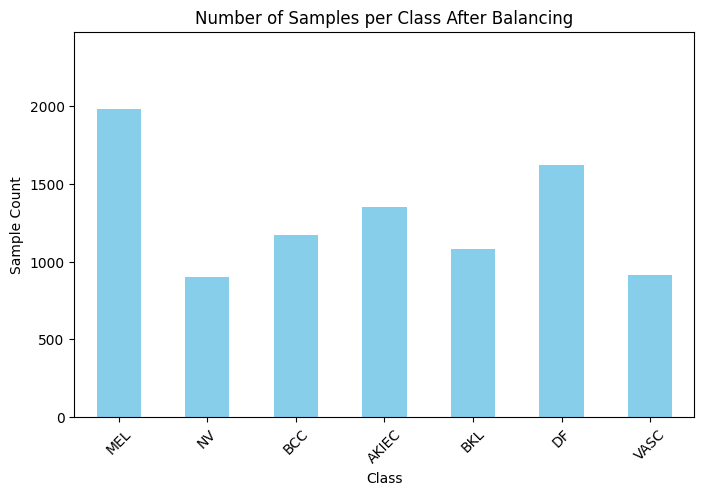

In [17]:
class_counts = df[classes].sum()

# Plot bar chart
plt.figure(figsize=(8,5))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Samples per Class After Balancing')
plt.ylabel('Sample Count')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.ylim(0, max(class_counts) + 500)
plt.show()

In [23]:
augmenter = keras.Sequential([
    keras.layers.RandomRotation(factor=0.2),# Data aug: rotation
])

def load_and_preprocess_image(path, label, training=False):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)

    if training: # Data aug
        image = augmenter(image)

    image = tf.image.resize(image, [224, 224]) # Image resizing
    image = image / 255.0 # Pixel Normalising
    return image, label

def create_dataset(df, training=False, batch_size=8):
    image_path = df['img_path'].values
    labels = df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].values
    dataset = tf.data.Dataset.from_tensor_slices((image_path, labels))

    dataset = dataset.map(
        lambda x, y: load_and_preprocess_image(x, y, training),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if training:
        dataset = dataset.shuffle(512)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create dataset
df_train = create_dataset(df, training=True)

In [24]:
# Capture Ground Truth and transform dataframe for label use

df_validate = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/validate/ISIC2018_Task3_Validation_GroundTruth.csv')
base_path_validate = '/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/validate/images/'
df_validate['img_path'] = base_path_validate + df_validate['image']+'.jpg'

df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/test/ISIC2018_Task3_Test_GroundTruth.csv')
base_path_test = '/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/test/images/'
df_test['img_path'] = base_path_test + df_test['image']+'.jpg'

In [25]:
df_validate = create_dataset(df_validate, training=False)
df_test = create_dataset(df_test, training=False)

## Model

In [31]:
def plot_hist(hist, modelName):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title(f"{modelName} model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

### Custom CNN
1 convolutional layers (Conv2D followed by batch normalisation and MaxPooling2D) followed by other 2 convolutional layers (batch normalisation, max pooling and dropout layer), a flatten layer and a single fully-connected layer (256 neurons) with batch normalisation and dropout before final layer.<br><br>
**Learning rate**: 0.001 with ReduceLROnPlateau<br>
**Loss**: categorical cross-entropy<br>
**Batch size**: 32<br>
**Epochs**: 40

In [27]:
def build_model(input_shape=(224, 224, 3), num_classes=7):
    model = models.Sequential([
        layers.Input(input_shape),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = build_model()

In [28]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,787,335 (98.37 MB)

 Trainable params: 25,786,375 (98.37 MB)

 Non-trainable params: 960 (3.75 KB)

In [29]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.0001)

In [30]:
start_time = time.time()
histCNN = model.fit(df_train, epochs=40, validation_data=df_validate, callbacks=[learning_rate_reduction])
end_time = time.time()
duration = end_time - start_time
print(f"Model Custom CNN Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/40
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 471s 378ms/step - accuracy: 0.3115 - loss: 2.1652 - val_accuracy: 0.5440 - val_loss: 1.2651 - learning_rate: 0.0010
Epoch 2/40
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.4081 - loss: 1.5749 - val_accuracy: 0.4819 - val_loss: 1.2812 - learning_rate: 0.0010
Epoch 3/40
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.4807 - loss: 1.3684 - val_accuracy: 0.2021 - val_loss: 2.9181 - learning_rate: 0.0010
Epoch 4/40
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.4879 - loss: 1.3320 - val_accuracy: 0.6373 - val_loss: 4.6881 - learning_rate: 0.0010
Epoch 5/40
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.4821 - loss: 1.3799 - val_accuracy: 0.5130 - val_loss: 1.3409 - learning_rate: 0.0010
Epoch 6/40
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.5075 - loss: 1.3206 - val_accuracy: 0.5440 - val_loss: 1.3418 - learning_rate: 0.0010
Epoch 7/40
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accur

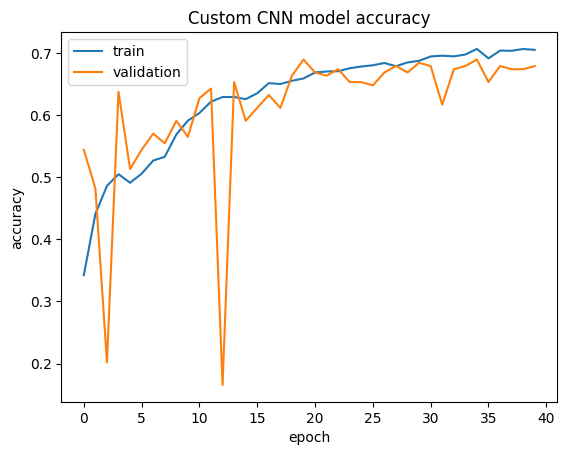

In [32]:
plot_hist(histCNN, "Custom CNN")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


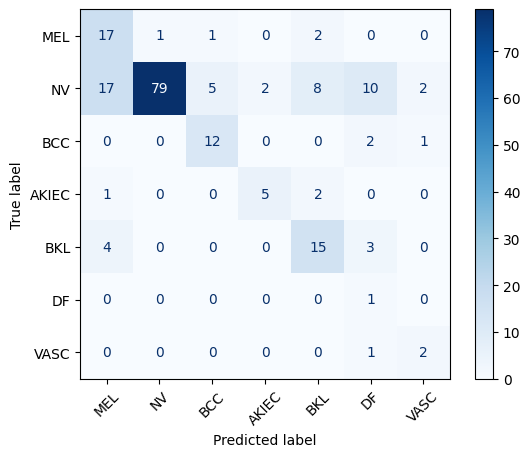

In [35]:
y_true = []
y_pred = []

for images, labels in df_validate:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation=45)

In [36]:
test_loss, *test_metrics = model.evaluate(df_test)
print(f"Test Loss: {test_loss}")
print(f"Test Metrics: {test_metrics}")

189/189 ━━━━━━━━━━━━━━━━━━━━ 62s 323ms/step - accuracy: 0.6129 - loss: 1.0081
Test Loss: 1.1790200471878052
Test Metrics: [0.5383597612380981]


In [ ]:
model_save_name = 'modelCNNNawaz2025.keras'
path = f"/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/saved_models/{model_save_name}"
model.save(path)

### ResNet152V2
Pre-trained ResNet152V2 followed by Global Average Pooling and 2 Dense layers (1024 and 512) with batch normalisation and dropout each.<br><br>
**Learning rate**: 0.001 with ReduceLROnPlateau<br>
**Loss**: categorical cross-entropy<br>
**Batch size**: 32<br>
**Epochs**: 30<br>

In [40]:
base_modelRN152 = tf.keras.applications.ResNet152V2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
    )

x = base_modelRN152.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(7, activation='softmax')(x)

modelRN152 = models.Model(inputs=base_modelRN152.input, outputs=outputs)

In [41]:
modelRN152.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
modelRN152.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 60,964,359 (232.56 MB)

 Trainable params: 60,817,543 (232.00 MB)

 Non-trainable params: 146,816 (573.50 KB)

In [42]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.000005)
start_time = time.time()
histRN152 = modelRN152.fit(df_train, epochs=30, validation_data=df_validate, callbacks=[learning_rate_reduction])
end_time = time.time()
duration = end_time - start_time
print(f"Model Custom CNN Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/30
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 295s 144ms/step - accuracy: 0.1836 - loss: 2.9384 - val_accuracy: 0.4301 - val_loss: 1.7806 - learning_rate: 1.0000e-05
Epoch 2/30
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 109s 95ms/step - accuracy: 0.3448 - loss: 2.2442 - val_accuracy: 0.5078 - val_loss: 1.5058 - learning_rate: 1.0000e-05
Epoch 3/30
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 109s 95ms/step - accuracy: 0.4252 - loss: 1.8952 - val_accuracy: 0.6062 - val_loss: 1.2601 - learning_rate: 1.0000e-05
Epoch 4/30
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 109s 94ms/step - accuracy: 0.5155 - loss: 1.6144 - val_accuracy: 0.6736 - val_loss: 1.1974 - learning_rate: 1.0000e-05
Epoch 5/30
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 109s 94ms/step - accuracy: 0.5593 - loss: 1.4682 - val_accuracy: 0.6580 - val_loss: 1.1024 - learning_rate: 1.0000e-05
Epoch 6/30
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 109s 94ms/step - accuracy: 0.5881 - loss: 1.3801 - val_accuracy: 0.6891 - val_loss: 1.0379 - learning_rate: 1.0000e-05
Epoch 7/30
1127/1127 ━━━━━━━━━━━━

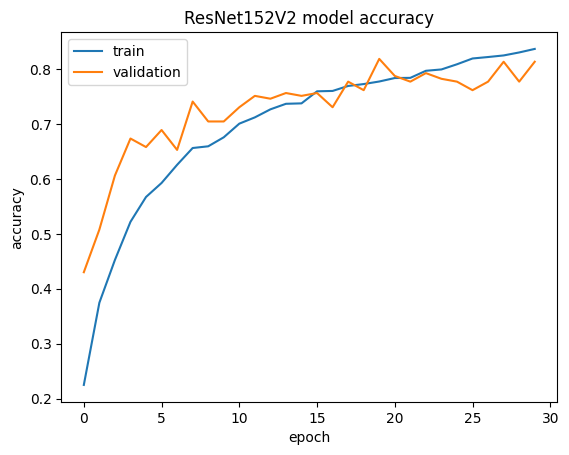

In [44]:
plot_hist(histRN152, "ResNet152V2")

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


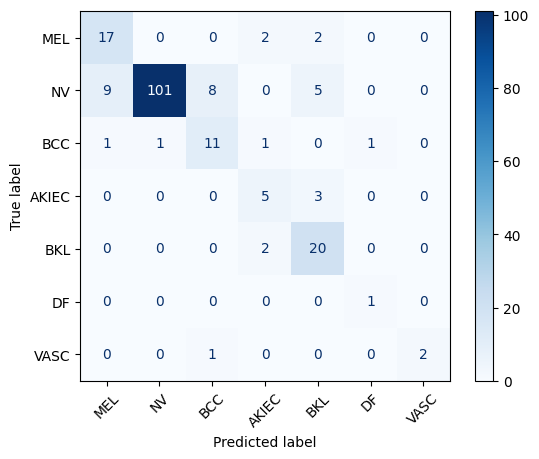

In [45]:
y_true = []
y_pred = []

for images, labels in df_validate:
    preds = modelRN152.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation=45)

In [46]:
test_loss, *test_metrics = modelRN152.evaluate(df_test)
print(f"Test Loss: {test_loss}")
print(f"Test Metrics: {test_metrics}")

189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7723 - loss: 0.8026
Test Loss: 0.9704903960227966
Test Metrics: [0.72817462682724]


In [43]:
model_save_name = 'modelRN152Nawaz2025.keras'
path = f"/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/saved_models/{model_save_name}"
modelRN152.save(path)